# sdsc [Part 1]

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import sys
from ipywidgets import interact

In [26]:
sys.path.append('src')
from motorControl import *
from trajectoryPlanning import *
from util import *

## Load Absolute Home, Upper right corner, out of the way, aligned with sharpie marks
f = open('savedPositions/absolute/home.p', 'r')
home = pickle.load(f)
f.close()

In [27]:
rc = connect(portName = "/dev/tty.usbserial-A9ETDN3N")
rc.Open()

1

### Initialized Motor Classes

- Really important to initialze these first to restore positions from last session!

In [28]:
#Initialize motor objects for each motor:
vL = Motor(address = 0x81, motorNumber = 2, rc = rc, signFlipped = True, \
           motorCounter = 0, kPID = [1e-2, 1.0])
vR = Motor(address = 0x81, motorNumber = 1, rc = rc, signFlipped = True, \
           motorCounter = 1, kPID = [1e-2, 1.0])
LR = Motor(address = 0x80, motorNumber = 1, rc = rc, signFlipped = True, 
           motorCounter = 2, kPID = [1e-2, 1.0])
FB = Motor(address = 0x80, motorNumber = 2, rc = rc, signFlipped = False, \
           motorCounter = 3, kPID = [1e-2, 1.0])
yaw = Motor(address = 0x82, motorNumber = 2, rc = rc, signFlipped = True, \
            motorCounter = 4, kPID = [1e-2, 1.0])
pitch = Motor(address = 0x82, motorNumber = 1, rc = rc, signFlipped = True, \
              motorCounter = 5, kPID = [1e-2, 1.0])

#Keep in a nice motor list:
motors = [vL, vR, LR, FB, yaw, pitch]

In [29]:
getPositions(motors)

[0, -10553, 62433, -153674, -69675, -14812]

In [30]:
home

[0, -10553, 62433, -153674, -69675, -14812]

In [37]:
MC = ManualControl(rc)
interact(MC.manualControl, leftUD = (-50, 50), rightUD = (-50, 50), leftRight = (-127, 127), \
         fB = (-127, 127), tilt = (-50, 50), pan = (-50, 50))

<function ipywidgets.widgets.interaction.<lambda>>

In [39]:
stopAll(rc)
savePositions(motors)
getPositions(motors)

[0, -10553, -2696, -45150, -54855, -14812]

In [30]:
stopAll(rc)
savePositions(motors)
getPositions(motors)

[-20984, 28981, 50687, -110995, -131571, 12334]

In [10]:
# levelRig(motors, home, rc, moveTime = 5.0)

## Save absolute home

- Only needed for hard resets

In [25]:
# # Center facing me shot
# f = open('savedPositions/absolute/home.p', 'wb')
# pickle.dump(getPositions(motors), f, protocol=pickle.HIGHEST_PROTOCOL)
# f.close()

## Save Relative Position

In [66]:
# delta = np.array(getPositions(motors))-np.array(home)
# f = open('savedPositions/relative/sdcs/A.p', 'wb')
# pickle.dump(delta, f, protocol=pickle.HIGHEST_PROTOCOL)
# f.close()

## Load Relative Positions

In [67]:
#Position A
f = open('savedPositions/relative/sdcs/A.p', 'r')
A = pickle.load(f)+np.array(home) #Return to absolute coords
f.close()

In [68]:
A

array([     0, -10553,  -2696, -45150, -54855, -14812])

In [69]:
getPositions(motors)

[0, -10553, -2696, -45150, -54855, -14812]

In [65]:
home

[0, -10553, 62433, -153674, -69675, -14812]

In [16]:
# #Position B
# f = open('savedPositions/relative/CSM/B.p', 'r')
# B = pickle.load(f)+np.array(home) #Return to absolute coords
# f.close()

In [17]:
# #Position C
# f = open('savedPositions/relative/CSM/C.p', 'r')
# C = pickle.load(f)+np.array(home) #Return to absolute coords
# f.close()

## Move the rig

In [73]:
targetPositions = home
totalTime = 15.0
rampTime = 5.0


startingPositions = getPositions(motors)
lookAheadTime = 1.0
tolerance = 100.0 #Anything less than this many ticks we're calling "Not a move"

motorsToMove = []
targetPositionsToMove = []
for i, motor in enumerate(motors):
    if abs(motor.getPosition()-targetPositions[i]) > tolerance:
        motorsToMove.append(motor)
        targetPositionsToMove.append(targetPositions[i])
        
trajectories = []
for i, motor in enumerate(motorsToMove):
    trajectories.append(SimpleQuadraticTrajectory(tu = rampTime, tt = totalTime, \
                                            p1 = motor.getPosition(), p2 = targetPositionsToMove[i]))
    

    
print np.array(targetPositions) - startingPositions
print 'Planning to move ' +  str(len(motorsToMove)) + ' motors.'

[   0    0 -327  632 6627    0]
Planning to move 3 motors.


In [ ]:
for motor in motorsToMove:
    motor.initialize(targetVelocityMin = -25000.0, targetVelocityMax = 25000.0)
    motor.clearTracking()
    
startTime = time.time()
timeElapsed = 0.0
    
while timeElapsed < totalTime:
    timeElapsed = time.time()-startTime
    
    for i, motor in enumerate(motorsToMove):
        lookAheadValue = trajectories[i].compute(timeElapsed + lookAheadTime)
        motor.controlledMove(targetPosition = lookAheadValue, timeToReach = lookAheadTime)
        
    if timeElapsed < totalTime/2.0:
        #A little hacky, but I don't care. I want to use a different controller gain on pitch for ramp down.
        motors[-1].kPID = [1e-2, 1.0]
    else:
        motors[-1].kPID = [2.5e-3, 1.0]

stopAll(rc)
savePositions(motors)
print getPositions(motors), targetPositions
print getPositions(motors) - np.array(targetPositions)

excess voltage on motor 2
voltage too low on motor 2
voltage too low on motor 2

In [53]:
stopAll(rc)
savePositions(motors)

In [54]:
A

array([    34, -10870,  -6769, -42293, -54843,  -6745])

In [55]:
getPositions(motors)

[34, -10870, 62249, -155591, -69690, -16362]

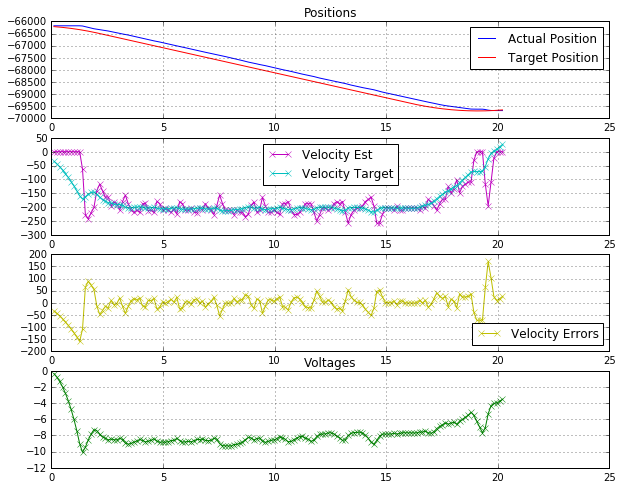

In [14]:
motors[4].visualizeMove()

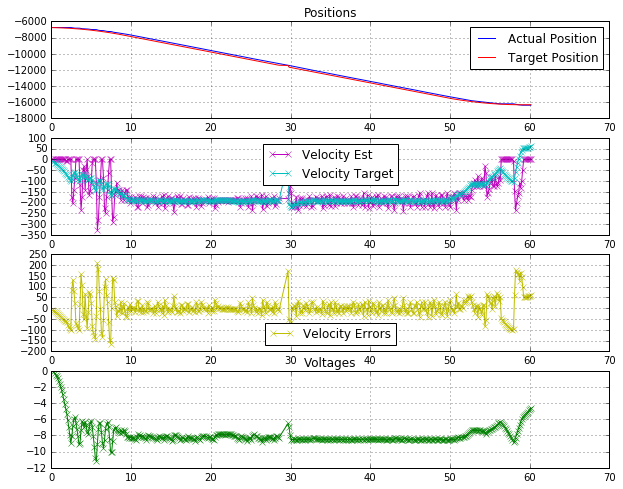

In [57]:
motors[5].visualizeMove()

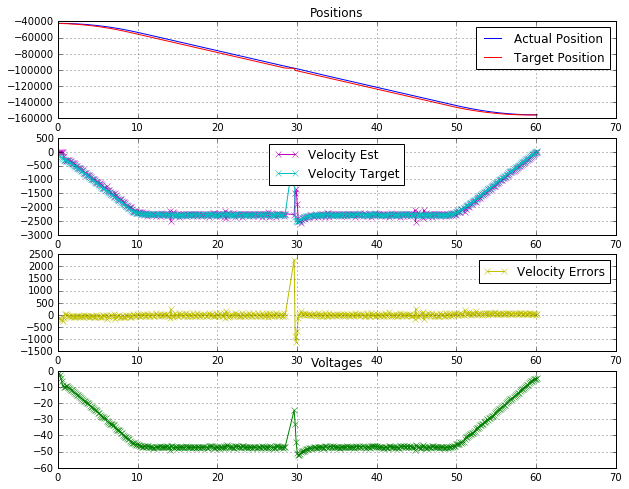

In [59]:
motors[3].visualizeMove()

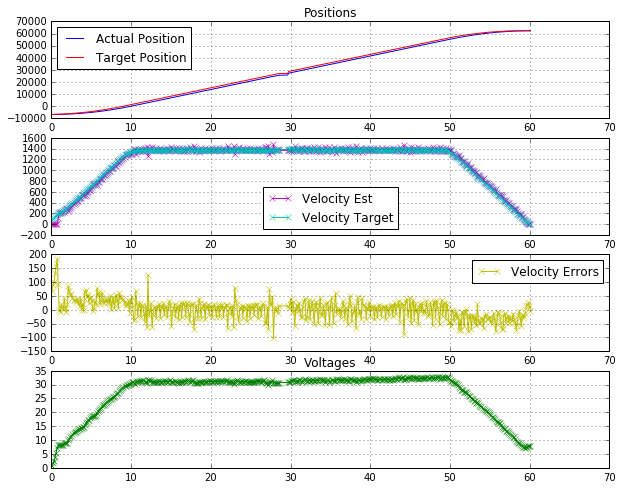

In [60]:
motors[2].visualizeMove()